# CH4-AIR Notebook 
This notebook contains all the methods and the 2 experiments

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize
from sklearn.utils.optimize import _check_optimize_result
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
import time
from sklearn.decomposition import PCA, SparsePCA
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import EarlyStopping
import sys

# Load and prepare data

In [2]:
#read the data into a dataframe
df = pd.read_csv('C:\\Users\\amol\\Documents\\PHD\\DISSERTATION\\NewData_flames_data_with_L1_L2_errors_CH4-AIR_with_trimming.txt')



#create an integer representation of the flame-id and add to the data frame
df['flame_key_int'] = df[' flame_key'].mul(10000000).astype(int)

#create an integer to determine if the flame is included by the framework in the manifold creation and reverselookup
#framework_untrimmed_flameids = [0.00115982, 0.00122087, 0.00128512, 0.00135276, 0.00142396, 0.0014989, 0.00157779, 0.00166083, 0.00174825, 0.00184026, 0.00193711, 0.00203907, 0.00214639, 0.00225936, 0.00237827, 0.01]

framework_untrimmed_flameids = ['2.0276547153583627E-4', '2.1343733845877503E-4', '2.2467088258818426E-4', '2.3649566588229923E-4', '2.4894280619189394E-4', '2.6204505914936203E-4', '2.7583690436774953E-4', '2.903546361765785E-4', '3.056364591332405E-4', '3.2172258856130585E-4', '3.3865535638032194E-4', '0.0032353354497370902']


framework_untrimmed_flame_key_ints = [int(float(framework_untrimmed_flameids[i])*10000000) for i in range(len(framework_untrimmed_flameids))]

def isFlame_included(flame_key_int):
    if flame_key_int in framework_untrimmed_flame_key_ints:
        ret_val = 1
    else:
        ret_val = 0
    return ret_val

df['is_flame_included_by_framework'] = df['flame_key_int'].map(lambda x: isFlame_included(x))

df['souener_deciles'] = pd.qcut(df['souener'],10)


### Create PCAs using all the data and add to DF


In [3]:
num_principal_components = 5

pca = PCA(n_components=num_principal_components)

icovariates = []
for c in df.columns:
    if c[0:2] == 'Yi':
        icovariates.append(c)

X = df[icovariates].values
        
pure_pca_dim_cols = ["PURE_PCA_"+str(i+1) for i in range(num_principal_components)]

pca.fit_transform(X)
        
df_pure_pca = pd.DataFrame(pca.transform(X), columns = pure_pca_dim_cols)
        
df = pd.concat([df,df_pure_pca], axis=1)


### Create Sparse PCA

In [4]:
sparsepca = SparsePCA(n_components=num_principal_components)
      
sparse_pca_dim_cols = ["SPARSE_PCA_"+str(i+1) for i in range(num_principal_components)]

sparsepca.fit_transform(X)
        
df_sparse_pca = pd.DataFrame(sparsepca.transform(X), columns = sparse_pca_dim_cols)
        
df = pd.concat([df,df_sparse_pca], axis=1)

### Create PCAs orthogonal to Zmix and add to DF

In [5]:
zmix_pca_dim_cols = ["Zmix_PCA_"+str(i+1) for i in range(num_principal_components)]

wopt = np.array([0.25131806468584, 1.0, 0.0, 0.0, 0.05926499970012948, 0.11189834407236524, 0.03053739933116691, 0.05926499970012948, 0.0, 0.07742283372149472, 0.14371856860332313, 0.14371856860332313, 0.20112514400193687, 1.0, 0.0, 0.0, 0.03473494419333629, 0.06713785861443991, 0.09743596683886535, 0.09743596683886535, 0.12582790137651187, 0.04027033873046593, 0.07742283372149472, 0.11180607885607882, 0.14371856860332313, 0.17341738612784788, 0.20112514400193687, 0.024566681794273966, 0.04795526192839207, 0.04795526192839207, 0.0, 0.06713048065088474, 0.12581494366075874, 0.17755300484072126, 0.034730994502665966, 0.0, 0.0, 0.0, 0.03249947443158002, 0.0, 0.0372961080230628, 0.07191024382448291, 0.024564706019978535, 0.023426986426879046, 0.023426986426879046, 0.023426986426879046, 0.0, 0.16374935944566987, 0.18286442054789118, 0.07024850027715426, 0.09152158240065958, 0.0, 0.0] , dtype=float)

w = wopt[:,np.newaxis]

# center the data
Xcenter = X - np.mean(X)

A = np.cov(X.T)

# calculate A - ww^TA
L = A - np.dot(np.dot(w,w.T),A)

# get the first eigen vector
values,vectors = np.linalg.eig(L)

vectors = np.real(vectors)

values = np.real(values)

df_zmix_pca = pd.DataFrame(df['flame_key_int'], columns = ['flame_key_int'])

df_zmix_pca[zmix_pca_dim_cols[0]] = Xcenter.dot(wopt)

for i in range(len(zmix_pca_dim_cols)-1):
    df_zmix_pca[zmix_pca_dim_cols[i+1]] = Xcenter.dot(vectors.T[i])

df_zmix_pca = pd.DataFrame(pca.transform(X), columns = zmix_pca_dim_cols)
        
df = pd.concat([df,df_zmix_pca], axis=1)

In [6]:
framework_included_flames_int = df[df['is_flame_included_by_framework'] == 1]['flame_key_int'].unique()

framework_excluded_flames_int = df[df['is_flame_included_by_framework'] == 0]['flame_key_int'].unique()

all_flames_int = df['flame_key_int'].unique()

def getTrainTestFlames(method):
    
    training_flames_int = []

    testing_flames_int = []

    if(method == "frameworkincludedexcludedequalsplit"):
    
        for x in framework_included_flames_int:
            training_flames_int.append(x)

        for x in framework_excluded_flames_int[::2]:
            training_flames_int.append(x)

        for x in framework_included_flames_int:
            testing_flames_int.append(x)

        for x in framework_excluded_flames_int[1::2]:
            testing_flames_int.append(x)
    
    elif(method == "frameworkincludedtrainexcludedtest"):
        for x in framework_included_flames_int:
            training_flames_int.append(x)

        for x in framework_excluded_flames_int:
            testing_flames_int.append(x)
    
    elif(method == "frameworkincludedtrainexcludedandincludedtest"):
        for x in framework_included_flames_int:
            training_flames_int.append(x)

        for x in framework_included_flames_int:
            testing_flames_int.append(x)

        for x in framework_excluded_flames_int:
            testing_flames_int.append(x)
            
    else:
        for x in all_flames_int:
            training_flames_int.append(x)
            testing_flames_int.append(x)
    
    df_training = df[df['flame_key_int'].isin(training_flames_int)]

    df_testing = df[df['flame_key_int'].isin(testing_flames_int)]
    
    return df_training,df_testing


def getTrainTestData(method):
    
    method_parts = method.split('_')

    df_trainingFlames, df_testingFlames = getTrainTestFlames(method_parts[1])

    if method_parts[0] == "ZmixCpv":
        X_train = df_trainingFlames [["Zmix","Cpv"]].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [["Zmix","Cpv"]].values
        
        Y_test = df_testingFlames [["souener"]].values
    
    elif method_parts[0] == "ZmixPCA":
        X_train = df_trainingFlames [zmix_pca_dim_cols].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [zmix_pca_dim_cols].values
        
        Y_test = df_testingFlames [["souener"]].values
        
    elif method_parts[0] == "SparsePCA":
        X_train = df_trainingFlames [sparse_pca_dim_cols].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [sparse_pca_dim_cols].values
        
        Y_test = df_testingFlames [["souener"]].values
    
    elif method_parts[0] == "PurePCA":
        X_train = df_trainingFlames [pure_pca_dim_cols].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [pure_pca_dim_cols].values
        
        Y_test = df_testingFlames [["souener"]].values
        
    else:
        X_train = df_trainingFlames [icovariates].values
        
        Y_train = df_trainingFlames [["souener"]].values
        
        X_test = df_testingFlames [icovariates].values
        
        Y_test = df_testingFlames [["souener"]].values
    
    return X_train,Y_train,X_test,Y_test

In [7]:
def computeError (Y_pred, Y_test):
    evaluation_df_1 = pd.DataFrame()

    evaluation_df_1['souener'] = Y_test.flatten()

    evaluation_df_1['souener_pred'] = Y_pred.flatten()

    evaluation_df_1['souener_pred_L1'] = evaluation_df_1['souener'] - evaluation_df_1['souener_pred'] 

    evaluation_df_1['souener_pred_L2'] = evaluation_df_1['souener_pred_L1'] * evaluation_df_1['souener_pred_L1']
    
    evaluation_df_1['souener_pred_L1Percent'] = ((evaluation_df_1['souener'] - evaluation_df_1['souener_pred'])/evaluation_df_1['souener']) 
    
    TotalAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()

    TotalSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()
    
    MeanAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()

    MeanSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()/evaluation_df_1['souener_pred_L2'].abs().count()
    
    NumPoints = evaluation_df_1['souener_pred_L1Percent'].abs().count()
    
    MeanPercentageError = evaluation_df_1['souener_pred_L1Percent'].abs().sum()/NumPoints
    
    return [TotalAbsoluteError,TotalSquaredError,MeanAbsoluteError,MeanSquaredError,MeanPercentageError,NumPoints]

def printError (err):
    TotalAbsoluteError = err[0]

    TotalSquaredError = err[1]

    MeanAbsoluteError = err[2]

    MeanSquaredError = err[3]

    MeanPercentageError = err[4]

    NumPoints = err[5]
    print ('Total Absolute Error: ', TotalAbsoluteError)
    print ('Mean Absolute Error: ', MeanAbsoluteError)
    print ('Mean Percentage Error: ', MeanPercentageError)
    print ('Total Squared Error: ', TotalSquaredError)
    print ('Mean Squared Error: ', MeanSquaredError)
    print ('Number of Points: ', NumPoints)

def computeAndPrintError(Y_pred, Y_test):    
    err = computeError (Y_pred, Y_test)
    printError (err)
    return err



In [8]:
class CustomGPR(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=150, gtol=1e-06, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter, 'gtol': self._gtol})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min




def fitGPAndCalcL1Err(X_train, Y_train, X_test, Y_test,kernel="Matern"):
    
    if kernel == "Matern_RationalQuadratic":
        
        # medium term irregularities
        k1 = 0.5* Matern(length_scale=2, nu=3/2)
        k2 = 0.5* RationalQuadratic(length_scale=1.0, alpha=1.0)
    
        '''
        k4 = 0.1**2 * RBF(length_scale=0.1) \+ WhiteKernel(noise_level=0.1**2,
                      noise_level_bounds=(1e-3, np.inf))  # noise terms
        '''
        kernel = k1 + k2
    
    elif kernel == "RationalQuadratic":
        
        # medium term irregularities
        kernel = RationalQuadratic(length_scale=1.0, alpha=1.0)    
    
    else:
        kernel = Matern(length_scale=2, nu=3/2)
    
    #gp_1 = gaussian_process.GaussianProcessRegressor(kernel=kernel)

    
    t = time.process_time()

    gp_1 = CustomGPR(kernel=kernel)
    
    gp_1.fit(X_train, Y_train)

    elapsed_time = time.process_time() - t

    print ("GP Time for Initial Fit: ", elapsed_time)
    
    t = time.process_time()
    
    #Y_pred = gp_1.predict(X_test, return_std=False)
    Y_pred = gp_1.predict(X_test, return_std=False)
    
    elapsed_time = time.process_time() - t

    print ("GP Time for Prediction: ", elapsed_time)
    
    err = computeAndPrintError(Y_pred, Y_test)
    
    return gp_1, err,Y_pred

In [9]:
df[["Zmix","Zmix_PCA_1","Zmix_PCA_2","Zmix_PCA_3","Zmix_PCA_4","Zmix_PCA_5","souener"]].describe().T

,count,mean,std,min,25%,50%,75%,max
Zmix,16439.0,4.300108e-01,2.603049e-01,4.542561e-03,2.126706e-01,3.964299e-01,6.312398e-01,9.954029e-01
Zmix_PCA_1,16439.0,-1.491193e-17,3.251065e-01,-4.908971e-01,-2.376216e-01,-1.147888e-01,2.351870e-01,7.919453e-01
Zmix_PCA_2,16439.0,-2.571768e-17,2.386448e-01,-3.177493e-01,-1.897668e-01,-4.598998e-02,1.333045e-01,7.843393e-01
Zmix_PCA_3,16439.0,4.220995e-18,6.042086e-02,-1.516243e-01,-2.527337e-02,3.242711e-03,3.535094e-02,1.816229e-01
Zmix_PCA_4,16439.0,-1.042079e-17,1.796528e-02,-4.138498e-02,-1.144243e-02,-1.985400e-03,7.268634e-03,5.825246e-02
Zmix_PCA_5,16439.0,-2.441424e-18,1.219560e-02,-2.677573e-02,-8.928763e-03,-4.546677e-04,8.275492e-03,2.862440e-02
souener,16439.0,1.235775e+10,2.959109e+10,-2.857737e+09,4.570219e+07,1.462231e+09,8.148453e+09,2.041413e+11


In [10]:
df["souener"].describe()

count    1.643900e+04
mean     1.235775e+10
std      2.959109e+10
min     -2.857737e+09
25%      4.570219e+07
50%      1.462231e+09
75%      8.148453e+09
max      2.041413e+11
Name: souener, dtype: float64

## DNN Method Support Functions

In [11]:
from numpy import genfromtxt
def get_neighborhood(neighborhooddisttype,datasettype):
    #neighbors_cosine_dataset_test_ZmixPCA_frameworkincludedexcludedequalsplit
    train_filename = "neighbors_" + neighborhooddisttype + "_dataset_train_" + datasettype + ".csv"
    test_filename = "neighbors_" + neighborhooddisttype + "_dataset_test_" + datasettype + ".csv"
    neighbors_dataset_train = genfromtxt(train_filename, delimiter=',')
    neighbors_dataset_test = genfromtxt(test_filename, delimiter=',')
    return neighbors_dataset_train,neighbors_dataset_test

def computeAndSaveNeighborhood():        
    # Train distance function
    neighbors_dataset_train = list()

    for i in range(X_train.shape[0]):
        neighbors_dataset_train.append(get_neighbors(X_train, Y_train, X_train[i], num_neighbors,"manhattan"))

    # Test distance function
    neighbors_dataset_test = list()

    for i in range(X_test.shape[0]):
        neighbors_dataset_test.append(get_neighbors(X_train, Y_train, X_test[i], num_neighbors,"manhattan"))

    neighbors_dataset_train = np.asarray(neighbors_dataset_train)
    neighbors_dataset_test = np.asarray(neighbors_dataset_test)
    from numpy import savetxt
    savetxt('neighbors_dataset_train_ZmixPCA.csv', neighbors_dataset_train, delimiter=',')
    savetxt('neighbors_dataset_test_ZmixPCA.csv', neighbors_dataset_test, delimiter=',')

In [12]:
# Example of getting neighbors for an instance
from math import sqrt
from scipy import spatial

num_neighbors = 48

# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

# calculate the Euclidean distance between two vectors
def weighted_euclidean_distance(row1, row2):
    distance = 0.0
    j = len(row1)
    for i in range(len(row1)-1):
        distance += j*(row1[i] - row2[i])**2
        j = j -1
    return sqrt(distance)

# calculate the Manhattan distance between two vectors
def weighted_manhattan_distance(row1, row2):
    distance = 0.0
    j = len(row1)
    for i in range(len(row1)-1):
        distance += j* abs(row1[i] - row2[i])
        j = j -1
    return distance

# calculate the Manhattan distance between two vectors
def manhattan_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += abs(row1[i] - row2[i])
    return distance

def cosine_distance(row1, row2):
    distance = 0.0
    distance = 1 - spatial.distance.cosine(row1, row2)
    return distance


# Locate the most similar neighbors
def get_neighbors(train, train_label, test_row, num_neighbors,dist_type):
    
    distances = list()
    
    i = 0
    
    for train_row in train:
        
        if dist_type == "cosine":
            dist = cosine_distance(test_row, train_row)
        elif dist_type == "manhattan":
            dist = manhattan_distance(test_row, train_row)    
        elif dist_type == "weighted_manhattan":
            dist = weighted_manhattan_distance(test_row, train_row)    
        elif dist_type == "weighted_euclidean":
            #euclidean":
            dist = weighted_euclidean_distance(test_row, train_row)
        else:
            #euclidean":
            dist = euclidean_distance(test_row, train_row)
        
        distances.append((train_label[i],train_row, dist))
        
        i = i + 1
    
    distances.sort(key=lambda tup: tup[2])
   
    neighbors = list()
    
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    
    neighbors = np.asarray(neighbors).flatten()
    
    return neighbors

In [13]:
def getResiduals(Y_test,Y_pred):
    evaluation_df_1 = pd.DataFrame()

    evaluation_df_1['souener'] = Y_test.flatten()

    evaluation_df_1['souener_pred'] = Y_pred.flatten()

    evaluation_df_1['res'] = evaluation_df_1['souener'] - evaluation_df_1['souener_pred'] 
   
    return evaluation_df_1['res'].values


In [14]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [Souener]')
    plt.legend()
    plt.grid(True)
    
   

In [15]:
def plot_loss_physics_and_regression(history):
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    
    ax.plot(history.history['prediction_loss'], label='loss')
    ax.plot(history.history['val_prediction_loss'], label='val_loss')
    ax.set_title('Souener Prediction Loss')
    ax.set(xlabel='Epoch', ylabel='Souener Error')
    ax.legend()

    ax2.plot(history.history['physics_loss'], label='loss')
    ax2.plot(history.history['val_physics_loss'], label='val_loss')
    ax2.set_title('Physics Loss')
    ax2.set(xlabel='Epoch', ylabel='Physics Error')
    ax2.legend()
        

In [16]:


# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model



In [17]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=45)

### 50% Random Data - All Species  

In [16]:
X_allSpecies = df[icovariates].values
X= df[zmix_pca_dim_cols].values
Y = df["souener"].values
from sklearn.utils import shuffle
X_allSpecies_shuffled,X_shuffled, Y_shuffled = shuffle(X_allSpecies,X,Y, random_state=0)


X_allSpecies_train = X_allSpecies_shuffled[::2]
X_train = X_shuffled[::2]
Y_train = Y_shuffled[::2]

X_allSpecies_test = X_allSpecies_shuffled[1::2]
X_test = X_shuffled[1::2]
Y_test = Y_shuffled[1::2]

Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

In [17]:
Y_test

array([[5.58632012e+09],
       [4.02360148e+09],
       [5.81072585e+08],
       ...,
       [7.87871399e+10],
       [3.31228134e+08],
       [1.02734466e+10]])

In [18]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# create scaler
scaler_species = MinMaxScaler()
# fit and transform in one step
normalized_species_train = scaler_species.fit_transform(X_allSpecies_train)
normalized_species_test = scaler_species.fit_transform(X_allSpecies_test)

# create scaler
scaler_zmixpca = MinMaxScaler()
# fit and transform in one step
normalized_zmixpca_train = scaler_zmixpca.fit_transform(X_train)
normalized_zmixpca_test = scaler_zmixpca.fit_transform(X_test)



scaler_souener = MinMaxScaler()
# fit and transform in one step



normalized_souener_train = scaler_souener.fit_transform(Y_train)
normalized_souener_test = scaler_souener.fit_transform(Y_test)

normalized_souener_train = normalized_souener_train.flatten()
normalized_souener_test = normalized_souener_test.flatten()

Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

In [19]:
train_size = normalized_souener_train.shape[0]

## Bayesian PCDNN

In [98]:
'''
 = layers.Dense(64, activation=activation_fn)(x)
x = layers.Dense(128, activation=activation_fn)(x)
x = layers.Dense(256, activation=activation_fn)(x)
x = layers.Dense(512, activation=activation_fn)(x)
x = layers.Dense(256, activation=activation_fn)(x)
x = layers.Dense(128, activation=activation_fn)(x)
x = layers.Dense(64, activation=activation_fn)(x)
x = layers.Dense(32, activation=activation_fn)(x)
#bayesian layer
x = tfp.layers.DenseVariational(
            units=512,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(x)

'''
activation_fn = "sigmoid" #"relu"


species_inputs = keras.Input(shape=(53,), name="species_input")

linear_reduced_dims = layers.Dense(5, name="linear_layer")(species_inputs)

#bayesian layer
x = tfp.layers.DenseVariational(
            units=128,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(linear_reduced_dims)

#Predict the source energy
souener_pred = layers.Dense(1, name="prediction")(x)

physics_pred = layers.Dense(5, name="physics")(linear_reduced_dims)

model = keras.Model(
    inputs=[species_inputs],
    outputs=[souener_pred, physics_pred],
)

model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
linear_layer (Dense)            (None, 5)            270         species_input[0][0]              
__________________________________________________________________________________________________
dense_variational_3 (DenseVaria (None, 128)          296064      linear_layer[0][0]               
__________________________________________________________________________________________________
prediction (Dense)              (None, 1)            129         dense_variational_3[0][0]        
_______________________________________________________________________________________

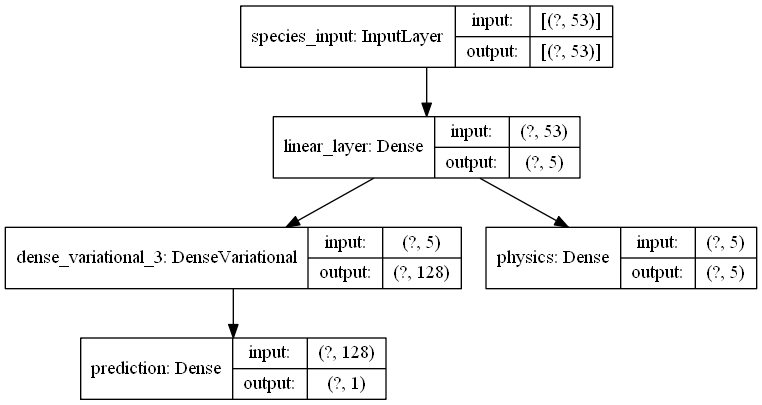

In [99]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [100]:
opt = keras.optimizers.RMSprop(learning_rate=0.001) #keras.optimizers.Adam(learning_rate=0.01)
model.compile(
    optimizer=opt,
    loss={
        "physics": keras.losses.MeanAbsoluteError(),
        "prediction": keras.losses.MeanAbsoluteError(),
    },
    loss_weights=[2.0, 0.2],
)



In [101]:
%%time
#batch_size=100,
history = model.fit(normalized_species_train, 
                    {
                        "physics": normalized_zmixpca_train,
                        "prediction":normalized_souener_train#Y_train
                    },
                    validation_split=0.2,
                    verbose=0, 
                    epochs=100
                   )

Wall time: 5min 41s


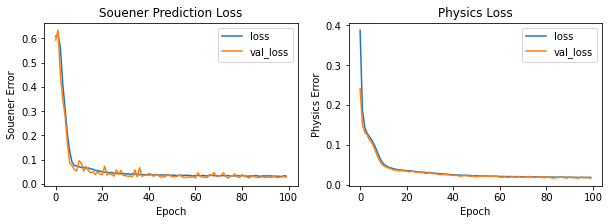

In [102]:
plot_loss_physics_and_regression(history)

In [103]:
def compute_predictions(model,test_dataset,actual_target, iterations=100):
    predicted = []
    for _ in range(iterations):
        predicted.append(model.predict(test_dataset)[0])
    predicted = np.concatenate(predicted, axis=1)

     
    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_min = np.min(predicted, axis=1).tolist()
    prediction_max = np.max(predicted, axis=1).tolist()
    prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()

    '''
    for idx in range(actual_target.shape[0]):
        print(
            f"Predictions mean: {round(prediction_mean[idx], 2)}, "
            f"min: {round(prediction_min[idx], 2)}, "
            f"max: {round(prediction_max[idx], 2)}, "
            f"range: {round(prediction_range[idx], 2)} - "
            f"Actual: {actual_target[idx][0]}"
        )
    '''
    return predicted, prediction_mean

#

In [104]:
predicted, prediction_mean = compute_predictions(model,normalized_species_test,normalized_souener_test)

In [105]:
'''
predictions = model.predict(normalized_species_test)

normalized_souener_pred = predictions[0]

normalized_zmixpca_pred = predictions[1]
'''

'\npredictions = model.predict(normalized_species_test)\n\nnormalized_souener_pred = predictions[0]\n\nnormalized_zmixpca_pred = predictions[1]\n'

In [106]:
prediction_mean = np.array(prediction_mean).reshape(len(prediction_mean) ,1)

In [107]:
Y_pred =scaler_souener.inverse_transform(prediction_mean) #scaler_souener.inverse_transform(normalized_souener_pred)

In [108]:
Y_pred = Y_pred.flatten()

In [109]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  26841179424747.652
Mean Absolute Error:  3265747587.875368
Mean Percentage Error:  1717.6337989115746
Total Squared Error:  2.2459118243374034e+23
Mean Squared Error:  2.732585258957785e+19
Number of Points:  8219


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

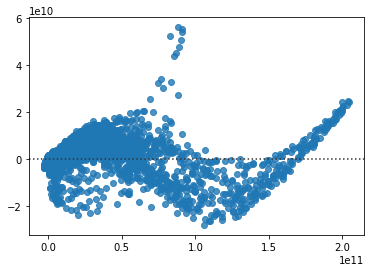

In [110]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

In [62]:
#Model Saved for the following configuration
'''
Total Absolute Error:  4075696778120.0723
Mean Absolute Error:  495887185.56029594
model.save("pcdnn_paper_1")
'''

'\nTotal Absolute Error:  4075696778120.0723\nMean Absolute Error:  495887185.56029594\nmodel.save("pcdnn_paper_1")\n'

### Full Bayesian Network

In [21]:
X_allSpecies = df[icovariates].values
X= df[zmix_pca_dim_cols].values
Y = df["souener"].values
from sklearn.utils import shuffle
X_allSpecies_shuffled,X_shuffled, Y_shuffled = shuffle(X_allSpecies,X,Y, random_state=0)


X_allSpecies_train = X_allSpecies_shuffled[::2]
X_train = X_shuffled[::2]
Y_train = Y_shuffled[::2]

X_allSpecies_test = X_allSpecies_shuffled[1::2]
X_test = X_shuffled[1::2]
Y_test = Y_shuffled[1::2]

Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

In [22]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import QuantileTransformer,MinMaxScaler

# create scaler
scaler_species = MinMaxScaler()
# fit and transform in one step
normalized_species_train = scaler_species.fit_transform(X_allSpecies_train)
normalized_species_test = scaler_species.fit_transform(X_allSpecies_test)

# create scaler
scaler_zmixpca = MinMaxScaler()
# fit and transform in one step
normalized_zmixpca_train = scaler_zmixpca.fit_transform(X_train)
normalized_zmixpca_test = scaler_zmixpca.fit_transform(X_test)



scaler_souener = MinMaxScaler()#QuantileTransformer()#MinMaxScaler()
# fit and transform in one step



normalized_souener_train = scaler_souener.fit_transform(Y_train)
normalized_souener_test = scaler_souener.fit_transform(Y_test)

normalized_souener_train = normalized_souener_train.flatten()
normalized_souener_test = normalized_souener_test.flatten()

In [28]:
species_inputs = keras.Input(shape=(53,), name="species_input")

linear_reduced_dims = layers.Dense(5, name="linear_layer")(species_inputs)

#bayesian layer
x = tfp.layers.DenseVariational(
            units=64,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(linear_reduced_dims)

#Predict the source energy

# Create a probabilisticå output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
distribution_params = layers.Dense(units=2)(x)

souener_pred = tfp.layers.IndependentNormal(1, name="prediction")(distribution_params)

model = keras.Model(
    inputs=[species_inputs],
    outputs=souener_pred,
)

model.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3

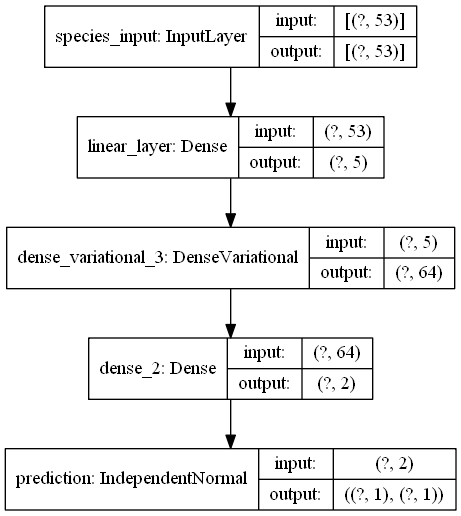

In [61]:
tf.keras.utils.plot_model(model,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [29]:
def negative_loglikelihood(targets, estimated_distribution):
    #tf.print("\n targets:", targets, " estimated_distribution:",estimated_distribution, output_stream=sys.stdout)
    return -estimated_distribution.log_prob(targets)

opt = keras.optimizers.RMSprop(learning_rate=0.001) #keras.optimizers.Adam(learning_rate=0.01)
model.compile(
    optimizer=opt,
    loss=negative_loglikelihood,
    metrics=[keras.metrics.RootMeanSquaredError()]
)




In [30]:
%%time
#batch_size=100,
#normalized_souener_train
history = model.fit(normalized_species_train, normalized_souener_train,
                    validation_split=0.2,
                    verbose=0, 
                    epochs=100
                   )

Wall time: 1min 28s


In [31]:
def plot_rmse_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)

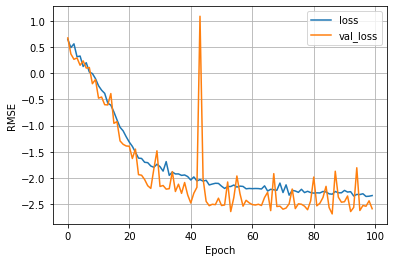

In [32]:
plot_rmse_loss(history)

In [33]:
def compute_predictions(model,test_dataset,actual_target, iterations=100):
    prediction_distribution = model(test_dataset)#don't need a .predict here
    prediction_mean = prediction_distribution.mean().numpy()
    prediction_stdv = prediction_distribution.stddev().numpy()


    # The 95% CI is computed as mean ± (1.96 * stdv)
    upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
    lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
    prediction_stdv = prediction_stdv.tolist()

    for idx in range(actual_target.shape[0]):
        print(
            f"Prediction mean: {round(prediction_mean[idx][0],2)},"
            f"stddev: {round(prediction_stdv[idx][0],2)},"
            f"95% CI: [{round(upper[idx][0], 2)} - {round(lower[idx][0], 2)}]"
            f" - Actual: {actual_target[idx]}"
        )    
    return prediction_distribution

In [34]:
#normalized_souener_pred
prediction_distribution = compute_predictions(model,normalized_species_test,normalized_souener_test)

Prediction mean: 0.05999999865889549,stddev: 0.02,95% CI: [0.09 - 0.02] - Actual: 0.040647661536462175
Prediction mean: 0.05000000074505806,stddev: 0.02,95% CI: [0.09 - 0.02] - Actual: 0.03309711834984487
Prediction mean: 0.029999999329447746,stddev: 0.01,95% CI: [0.06 - 0.0] - Actual: 0.01646394940843747
Prediction mean: 0.46000000834465027,stddev: 0.1,95% CI: [0.66 - 0.26] - Actual: 0.5074720117871211
Prediction mean: 0.03999999910593033,stddev: 0.02,95% CI: [0.08 - 0.01] - Actual: 0.029151479513598255
Prediction mean: 0.03999999910593033,stddev: 0.02,95% CI: [0.08 - 0.01] - Actual: 0.017384556693844158
Prediction mean: 0.029999999329447746,stddev: 0.01,95% CI: [0.06 - -0.0] - Actual: 0.01411330941821572
Prediction mean: 0.019999999552965164,stddev: 0.01,95% CI: [0.05 - -0.01] - Actual: 0.013785349335037268
Prediction mean: 0.019999999552965164,stddev: 0.02,95% CI: [0.05 - -0.01] - Actual: 0.009474841576916807
Prediction mean: 0.41999998688697815,stddev: 0.08,95% CI: [0.57 - 0.27] - 

Prediction mean: 0.029999999329447746,stddev: 0.01,95% CI: [0.06 - -0.0] - Actual: 0.013656832101573637
Prediction mean: 0.5099999904632568,stddev: 0.21,95% CI: [0.92 - 0.1] - Actual: 0.7607155922937308
Prediction mean: 0.029999999329447746,stddev: 0.01,95% CI: [0.05 - -0.0] - Actual: 0.013869478883796289
Prediction mean: 0.28999999165534973,stddev: 0.05,95% CI: [0.4 - 0.19] - Actual: 0.28349589825265187
Prediction mean: 0.029999999329447746,stddev: 0.01,95% CI: [0.05 - -0.0] - Actual: 0.013950051324010466
Prediction mean: 0.029999999329447746,stddev: 0.02,95% CI: [0.06 - -0.0] - Actual: 0.024028966764979703
Prediction mean: 0.10000000149011612,stddev: 0.02,95% CI: [0.15 - 0.06] - Actual: 0.06661016215323178
Prediction mean: 0.09000000357627869,stddev: 0.02,95% CI: [0.13 - 0.05] - Actual: 0.051686192978342475
Prediction mean: 0.019999999552965164,stddev: 0.01,95% CI: [0.05 - -0.01] - Actual: 0.0020186334239963976
Prediction mean: 0.019999999552965164,stddev: 0.01,95% CI: [0.05 - -0.01]

Prediction mean: 0.3799999952316284,stddev: 0.06,95% CI: [0.48 - 0.27] - Actual: 0.37193003412615594
Prediction mean: 0.029999999329447746,stddev: 0.02,95% CI: [0.06 - -0.0] - Actual: 0.018873670732414652
Prediction mean: 0.029999999329447746,stddev: 0.01,95% CI: [0.05 - -0.0] - Actual: 0.013663016117927496
Prediction mean: 0.5099999904632568,stddev: 0.23,95% CI: [0.97 - 0.06] - Actual: 0.8516763781338179
Prediction mean: 0.019999999552965164,stddev: 0.01,95% CI: [0.05 - -0.01] - Actual: 0.011966703674868764
Prediction mean: 0.029999999329447746,stddev: 0.01,95% CI: [0.06 - -0.0] - Actual: 0.013665329185455311
Prediction mean: 0.18000000715255737,stddev: 0.03,95% CI: [0.24 - 0.12] - Actual: 0.12599971615793212
Prediction mean: 0.07999999821186066,stddev: 0.02,95% CI: [0.12 - 0.04] - Actual: 0.060304609064385714
Prediction mean: 0.029999999329447746,stddev: 0.01,95% CI: [0.06 - -0.0] - Actual: 0.015123972434889282
Prediction mean: 0.11999999731779099,stddev: 0.02,95% CI: [0.16 - 0.07] -

Prediction mean: 0.019999999552965164,stddev: 0.01,95% CI: [0.05 - -0.01] - Actual: 0.013719327635527448
Prediction mean: 0.019999999552965164,stddev: 0.01,95% CI: [0.05 - -0.0] - Actual: 0.013898413773742936
Prediction mean: 0.05000000074505806,stddev: 0.02,95% CI: [0.08 - 0.01] - Actual: 0.022288021937081546
Prediction mean: 0.019999999552965164,stddev: 0.02,95% CI: [0.05 - -0.01] - Actual: 0.0017279351917983844
Prediction mean: 0.12999999523162842,stddev: 0.03,95% CI: [0.19 - 0.08] - Actual: 0.06629807229594126
Prediction mean: 0.019999999552965164,stddev: 0.01,95% CI: [0.05 - -0.01] - Actual: 0.01441562600152568
Prediction mean: 0.029999999329447746,stddev: 0.02,95% CI: [0.06 - -0.0] - Actual: 0.009551602039819513
Prediction mean: 0.029999999329447746,stddev: 0.01,95% CI: [0.06 - -0.0] - Actual: 0.01391548190886644
Prediction mean: 0.029999999329447746,stddev: 0.02,95% CI: [0.06 - -0.0] - Actual: 0.02377425138068181
Prediction mean: 0.09000000357627869,stddev: 0.02,95% CI: [0.13 - 

Prediction mean: 0.029999999329447746,stddev: 0.02,95% CI: [0.06 - -0.0] - Actual: 0.01715468379322642
Prediction mean: 0.10999999940395355,stddev: 0.02,95% CI: [0.15 - 0.06] - Actual: 0.07307376379850385
Prediction mean: 0.5,stddev: 0.18,95% CI: [0.85 - 0.15] - Actual: 0.6499667130046154
Prediction mean: 0.5199999809265137,stddev: 0.26,95% CI: [1.02 - 0.01] - Actual: 0.8609495424314891
Prediction mean: 0.029999999329447746,stddev: 0.02,95% CI: [0.06 - -0.0] - Actual: 0.02286661259618345
Prediction mean: 0.05000000074505806,stddev: 0.02,95% CI: [0.08 - 0.01] - Actual: 0.03355680202542282
Prediction mean: 0.029999999329447746,stddev: 0.01,95% CI: [0.06 - 0.0] - Actual: 0.013656423081331994
Prediction mean: 0.3400000035762787,stddev: 0.05,95% CI: [0.44 - 0.23] - Actual: 0.2705139015871806
Prediction mean: 0.019999999552965164,stddev: 0.01,95% CI: [0.05 - -0.01] - Actual: 0.013904096508864297
Prediction mean: 0.019999999552965164,stddev: 0.01,95% CI: [0.05 - -0.01] - Actual: 0.00729260162

Prediction mean: 0.019999999552965164,stddev: 0.01,95% CI: [0.05 - -0.0] - Actual: 0.013702572863659685
Prediction mean: 0.029999999329447746,stddev: 0.02,95% CI: [0.06 - 0.0] - Actual: 0.017640752247501265
Prediction mean: 0.029999999329447746,stddev: 0.02,95% CI: [0.06 - -0.0] - Actual: 0.015029675308236914
Prediction mean: 0.029999999329447746,stddev: 0.02,95% CI: [0.06 - 0.0] - Actual: 0.015523309632552287
Prediction mean: 0.05999999865889549,stddev: 0.02,95% CI: [0.1 - 0.03] - Actual: 0.04957936999561806
Prediction mean: 0.20000000298023224,stddev: 0.03,95% CI: [0.26 - 0.14] - Actual: 0.12475722242687164
Prediction mean: 0.029999999329447746,stddev: 0.02,95% CI: [0.06 - -0.0] - Actual: 0.016588615619148494
Prediction mean: 0.46000000834465027,stddev: 0.1,95% CI: [0.66 - 0.26] - Actual: 0.5650959031376132
Prediction mean: 0.05000000074505806,stddev: 0.02,95% CI: [0.09 - 0.02] - Actual: 0.02803892844931266
Prediction mean: 0.029999999329447746,stddev: 0.02,95% CI: [0.06 - 0.0] - Act

In [35]:
prediction_distribution = model(normalized_species_test)

In [39]:
prediction_mean = prediction_distribution.mean().numpy()
prediction_mean  

array([[0.03395192],
       [0.03708353],
       [0.0076875 ],
       ...,
       [0.37023395],
       [0.00683105],
       [0.05432768]], dtype=float32)

In [40]:
Y_pred = scaler_souener.inverse_transform(prediction_mean)

In [41]:
Y_pred = Y_pred.flatten()

In [42]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  28875879567692.223
Mean Absolute Error:  3513308135.745495
Mean Percentage Error:  937.066796401386
Total Squared Error:  6.675525966914747e+23
Mean Squared Error:  8.12206590450754e+19
Number of Points:  8219


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

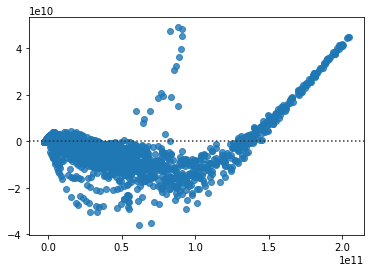

In [43]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

### Full Linear DNN

In [29]:
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras.constraints import UnitNorm, Constraint
from tensorflow.keras import backend as K
class WeightsOrthogonalityConstraint (Constraint):
    def __init__(self, encoding_dim, weightage = 1.0, axis = 0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage
        self.axis = axis

    def weights_orthogonality(self, w):
        tf.print("\n axis:",self.axis, output_stream=sys.stdout)
        if(self.axis==1):
            w = K.transpose(w)
        if(self.encoding_dim > 1):
            m = K.dot(K.transpose(w), w) - K.eye(self.encoding_dim)
            tf.print("\n m:",m)
            tf.print("\n self.weightage:",self.weightage)
            return self.weightage * K.sqrt(K.sum(K.square(m)))
        else:
            m = K.sum(w ** 2) - 1.
            return m

    def __call__(self, w):
        tf.print("\n w:", w)
        return self.weights_orthogonality(w)
    
class UncorrelatedFeaturesConstraint (Constraint):

    def __init__(self, encoding_dim, weightage=1.0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage

    def get_covariance(self, x):
        x_centered_list = []

        for i in range(self.encoding_dim):
            x_centered_list.append(x[:, i] - K.mean(x[:, i]))

        x_centered = tf.stack(x_centered_list)
        covariance = K.dot(x_centered, K.transpose(x_centered)) / tf.cast(x_centered.get_shape()[0], tf.float32)

        return covariance

    # Constraint penalty
    def uncorrelated_feature(self, x):
        if(self.encoding_dim <= 1):
            return 0.0
        else:
            output = K.sum(K.square(self.covariance - tf.math.multiply(self.covariance, K.eye(self.encoding_dim))))

            return output

    def __call__(self, x):
        self.covariance = self.get_covariance(x)
        return self.weightage * self.uncorrelated_feature(x)

In [23]:
X_allSpecies = df[icovariates].values
X= df[zmix_pca_dim_cols].values
Y = df["souener"].values
from sklearn.utils import shuffle
X_allSpecies_shuffled,X_shuffled, Y_shuffled = shuffle(X_allSpecies,X,Y, random_state=0)


X_allSpecies_train = X_allSpecies_shuffled[::2]
X_train = X_shuffled[::2]
Y_train = Y_shuffled[::2]

X_allSpecies_test = X_allSpecies_shuffled[1::2]
X_test = X_shuffled[1::2]
Y_test = Y_shuffled[1::2]

Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

In [24]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import QuantileTransformer,MinMaxScaler

# create scaler
scaler_species = MinMaxScaler()
# fit and transform in one step
normalized_species_train = scaler_species.fit_transform(X_allSpecies_train)
normalized_species_test = scaler_species.fit_transform(X_allSpecies_test)

# create scaler
scaler_zmixpca = MinMaxScaler()
# fit and transform in one step
normalized_zmixpca_train = scaler_zmixpca.fit_transform(X_train)
normalized_zmixpca_test = scaler_zmixpca.fit_transform(X_test)



scaler_souener = MinMaxScaler()#QuantileTransformer()#MinMaxScaler()
# fit and transform in one step



normalized_souener_train = scaler_souener.fit_transform(Y_train)
normalized_souener_test = scaler_souener.fit_transform(Y_test)

normalized_souener_train = normalized_souener_train.flatten()
normalized_souener_test = normalized_souener_test.flatten()

In [25]:
encoding_dim = 5
species_inputs = keras.Input(shape=(53,), name="species_input")

'''
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)

'''


x = layers.Dense(encoding_dim, activation="relu",use_bias = True,kernel_regularizer=WeightsOrthogonalityConstraint(encoding_dim, weightage=1., axis=0))(species_inputs)
x = layers.Dense(512, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(1, name="prediction")(x)

fullmodel = keras.Model(
    inputs=[species_inputs],
    outputs=[souener_pred],
)
#,kernel_constraint=UnitNorm(axis=0)
#,activity_regularizer=UncorrelatedFeaturesConstraint(encoding_dim, weightage=1.)
fullmodel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
species_input (InputLayer)   [(None, 53)]              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 270       
_________________________________________________________________
dense_1 (Dense)              (None, 512)               3072      
_________________________________________________________________
prediction (Dense)           (None, 1)                 513       
Total params: 3,855
Trainable params: 3,855
Non-trainable params: 0
_________________________________________________________________


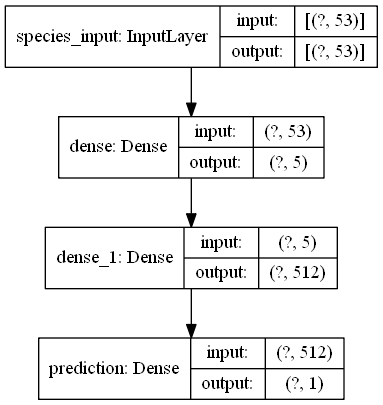

In [26]:
tf.keras.utils.plot_model(fullmodel,to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96)

In [27]:
fullmodel.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))

In [30]:
%%time
history = fullmodel.fit(normalized_species_train, 
                          normalized_souener_train,
                          validation_split=0.2,
                          verbose=0, 
                          epochs=10, 
                          callbacks=[es])

ValueError: in user code:

    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\keras\engine\training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:237 __call__
        total_loss_metric_value = math_ops.add_n(loss_metric_values)
    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\ops\math_ops.py:3512 add_n
        return gen_math_ops.add_n(inputs, name=name)
    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\ops\gen_math_ops.py:431 add_n
        "AddN", inputs=inputs, name=name)
    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\framework\op_def_library.py:744 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\framework\func_graph.py:593 _create_op_internal
        compute_device)
    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\framework\ops.py:3485 _create_op_internal
        op_def=op_def)
    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\framework\ops.py:1975 __init__
        control_input_ops, op_def)
    C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Shapes must be equal rank, but are 0 and 2
    	From merging shape 0 with other shapes. for '{{node AddN}} = AddN[N=2, T=DT_FLOAT](mean_absolute_error/weighted_loss/value, ReadVariableOp)' with input shapes: [], [53,5].


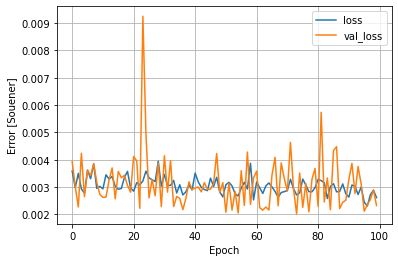

In [156]:
plot_loss(history)

In [157]:
predictions = fullmodel.predict(normalized_species_test)

normalized_souener_pred = predictions


In [158]:
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)

In [159]:
Y_pred = Y_pred.flatten()

In [160]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  121966493489275.5
Mean Absolute Error:  14839578232.05688
Mean Percentage Error:  1701.9413036580006
Total Squared Error:  9.025612120334381e+24
Mean Squared Error:  1.0981399343392604e+21
Number of Points:  8219


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

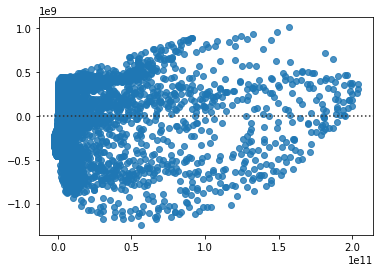

In [161]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))